# Importing Dependencies 

In [5]:
import torch
from torchvision import datasets, transforms, models  # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For MOBILENETV2


In [6]:
transform4 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # MobileNet-specific
])

In [7]:
dataset_mobilenet=datasets.ImageFolder("/kaggle/input/mepco-tropic-leaf/MepcoTropicLeaf-V1/Database", transform=transform4)

## Splitting the Dataset 


In [8]:
indices=list(range(len(dataset_mobilenet))) # dataset ko numerate karne ke liye
split=int(np.floor(0.70*len(dataset_mobilenet)))
validation=int(np.floor(0.60*split))

# agar tmre pass 100 samples hai
# toh split=70(ie 70% of the dataset)-> ee use hoga training and validation ke liye; remaining (30)30% used hoga as test set
# tb validation=42 (ie 60% of the dataset)-> ee use hoga for training ke liye; remaining (28)40% used hoga as Validation set
# toh phir training= 42%; validation= 28%; test=30%

print(f"length of train size : {validation}")
print(f"length of validation size : {split-validation}")
print(f"length of test size : {len(dataset_mobilenet)-split}")

np.random.shuffle(indices) # dataset me randomness laane ke liye

# ab actual splitting
train_indices, validation_indices, test_indices = (
    indices[:validation], # [:5]->0,1,2,3,4
    indices[validation:split],# [1:3]->1,2
    indices[split:],# [2:]-> 2,3,4,5,........
)

train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

# print(list(train_indices))
# print(list(validation_indices))
# print(list(test_indices))

# print(list(train_sampler))
# print(list(validation_sampler))
# print(list(test_sampler))


length of train size : 1585
length of validation size : 1058
length of test size : 1134


## No. of unique features 

In [9]:
targets_size = len(dataset_mobilenet.class_to_idx)# finding the total unique classes and storing it
print(targets_size)
print(list(dataset_mobilenet.class_to_idx.keys()))
num_classes_list = list(dataset_mobilenet.class_to_idx.values())# now numerating them
print(num_classes_list)

50
['Asthma Plant.zip', 'Avaram.zip', 'Balloon vine.zip', 'Bellyache bush (Green).zip', 'Benghal dayflower.zip', 'Big Caltrops.zip', 'Black-Honey Shrub.zip', 'Bristly Wild Grape.zip', 'Butterfly Pea.zip', 'Cape Gooseberry.zip', 'Common Wireweed.zip', 'Country Mallow.zip', 'Crown flower.zip', 'Green Chireta.zip', 'Holy Basil.zip', 'Indian CopperLeaf.zip', 'Indian Jujube.zip', 'Indian Sarsaparilla.zip', 'Indian Stinging Nettle.zip', 'Indian Thornapple.zip', 'Indian wormwood.zip', 'Ivy Gourd.zip', 'Kokilaksha.zip', 'Land Caltrops (Bindii).zip', 'Madagascar Periwinkle.zip', 'Madras Pea Pumpkin.zip', 'Malabar Catmint.zip', 'Mexican Mint.zip', 'Mexican Prickly Poppy.zip', 'Mountain Knotgrass.zip', 'Nalta Jute.zip', 'Night blooming Cereus.zip', 'Panicled Foldwing.zip', 'Prickly Chaff Flower.zip', 'Punarnava.zip', 'Purple Fruited Pea Eggplant.zip', 'Purple Tephrosia.zip', 'Rosary Pea.zip', 'Shaggy button weed.zip', 'Small Water Clover.zip', 'Spiderwisp.zip', 'Square Stalked Vine.zip', 'Stinkin

## Loading MOBILENETV2

In [13]:
model2 = models.mobilenet_v2(pretrained=True)

# Freeze all layers first
for param in model2.parameters():
    param.requires_grad = False

# Unfreeze last 3 inverted residual blocks (adjust as needed)
for layer in model2.features[-6:]:  # Last 6 layers
    for param in layer.parameters():
        param.requires_grad = True

# Modify classifier
model2.classifier[1] = nn.Linear(model2.classifier[1].in_features, targets_size)
model2.classifier[0] = nn.Dropout(p=0.3)  # Reduce dropout from 0.5 to 0.3

model2.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model2.classifier[1].in_features, 512),  # Hidden layer
    nn.ReLU(),
    nn.Linear(512, targets_size))

## Extracting Feature size 

In [14]:
n_features = model2.classifier[1].in_features #mobilenet; number of input features in the first fully connected layer
n_features

1280

## Overriding the calculations to GPU if available 

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) #checking if GPU is available
model2.to(device)

cuda


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## Optimizer and criterion for gradient descent 

In [16]:
criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
# calculates the loss during training, which will be later used by backpropagation to imporove the models accuracy
optimizer = torch.optim.Adam([
    {'params': model2.features[-6:].parameters(), 'lr': 1e-4},  # Higher LR for unfrozen
    {'params': model2.classifier.parameters(), 'lr': 1e-3}       # Even higher for classifier
], weight_decay=1e-5)  # Reduce weight decay #Add to the optimizer to penalize large weights
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
#adam optimiser is used to optimise the models parameters(weights of the model) to minimise the loss and hence increase the accuracy

## Actual Training 

### Data Transforms

In [17]:
# data_transforms = {
#     'train_loader': transforms.Compose([
#         transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), shear=5),
#         transforms.ColorJitter(hue=0.05, saturation=0.05),
#         transforms.RandomHorizontalFlip(),
#         transforms.Grayscale(num_output_channels=1),
#          transforms.RandomApply([transforms.GaussianBlur(kernel_size=7)], p=0.2),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5,), (0.5,)),
#     ]),
#     'validation_loader': transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize((0.5,), (0.5,)),
#     ])
# }

### Dividing into train, test, validation batches 

In [18]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset_mobilenet, batch_size=batch_size, sampler=train_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset_mobilenet, batch_size=batch_size, sampler=validation_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset_mobilenet, batch_size=batch_size, sampler=test_sampler
)

### Gradient Descent 

In [19]:
def batch_gd(model, criterion, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for e in range(epochs):

        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            train_loss.append(loss.item())  # torch to numpy world
            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)
        validation_loss = []

        for inputs, targets in validation_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            loss = criterion(output, targets)
            validation_loss.append(loss.item())  # torch to numpy world

        validation_loss = np.mean(validation_loss)
        train_losses[e] = train_loss
        dt = datetime.now() - t0
        print(f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Duration:{dt}")
        scheduler.step()
    return train_losses

In [20]:
train_losses_mobilenet = batch_gd(model2, criterion, train_loader, validation_loader, 10)

Epoch : 1/10 Train_loss:3.232 Duration:0:01:01.347428
Epoch : 2/10 Train_loss:1.258 Duration:0:01:00.823217
Epoch : 3/10 Train_loss:0.534 Duration:0:01:00.573175
Epoch : 4/10 Train_loss:0.358 Duration:0:01:00.225997
Epoch : 5/10 Train_loss:0.247 Duration:0:01:00.303209
Epoch : 6/10 Train_loss:0.181 Duration:0:00:59.971214
Epoch : 7/10 Train_loss:0.157 Duration:0:01:00.647952
Epoch : 8/10 Train_loss:0.134 Duration:0:01:00.296319
Epoch : 9/10 Train_loss:0.113 Duration:0:01:00.618896
Epoch : 10/10 Train_loss:0.107 Duration:0:01:01.000529


## Loss Graph 

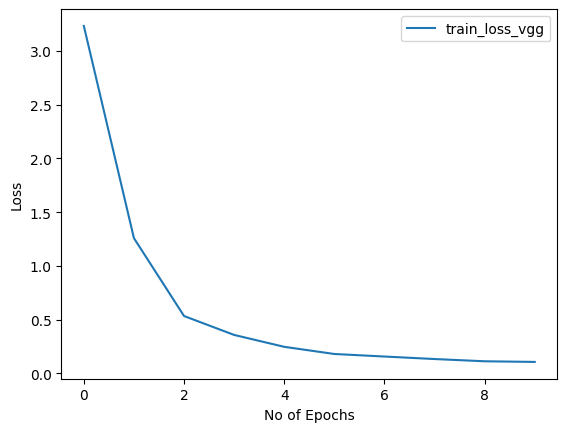

In [21]:
plt.plot(train_losses_mobilenet , label = 'train_loss_vgg')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()#validation loss ke liye 

## Accuracy 


In [22]:
def accuracy(loader):
    n_correct = 0
    n_total = 0
    model2.cuda()
    for inputs, targets in loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model2(inputs)
        #print(outputs)
        _, predictions = torch.max(outputs, 1)
        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

In [23]:
train_acc = accuracy(train_loader)
test_acc = accuracy(test_loader)
validation_acc = accuracy(validation_loader)

print(
    f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}"
)

Train Accuracy : 0.9753943217665615
Test Accuracy : 0.9320987654320988
Validation Accuracy : 0.8979206049149339
